## OpenAI commentary

*   Install required packages
*   Settings
*   Imports
*   Cache video
*   Extract key frames
*   Describe video
*   Combine video and audio
*   Install required packages



## Install required packages

In [1]:
!pip install -q pytube supervision openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 837.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00


## Settings

In [31]:
VIDEO_URL = 'https://www.youtube.com/watch?v=a-M3x-eZpV8'

# fill in your openai api key
OPENAI_API_KEY = ''
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"

# depending on your video, you may need to sample more or less frequently
FRAME_EXTRACTION_FREQUENCY_SECONDS = 4

PROMPT = (
    f"The uploaded series of images is from a single video. "
    f"The frames were sampled every {FRAME_EXTRACTION_FREQUENCY_SECONDS} seconds. "
    f"Make sure it takes about {FRAME_EXTRACTION_FREQUENCY_SECONDS // 2} seconds to voice the description of each frame. "
    f"Use exclamation points and capital letters to express excitement if necessary. "
    f"Describe the video using Marv Albert style."
)

## Imports

In [3]:
import os
import re
import cv2
import base64
import requests

import supervision as sv
import numpy as np

from openai import OpenAI
from pytube import YouTube

## Cache video

In [4]:
def format_video_title(title: str) -> str:
    """
    Formats the video title by replacing spaces with hyphens, converting to lowercase,
    and removing special characters including commas, hash symbols, and hyphens.

    Args:
        title (str): The original video title.

    Returns:
        str: The formatted video title.
    """
    title = title.lower()
    title = re.sub(r'[^\w\s-]', '', title)
    title = re.sub(r'[-\s]+', '-', title)
    return title


def download_youtube_video(url: str, output_path: str = '.'):
    """
    Downloads a YouTube video to a specified output path.

    Args:
        url (str): URL of the YouTube video.
        output_path (str): Path where the video will be saved. Defaults to the current directory.
    """
    try:
        yt = YouTube(url)
        video_stream = yt.streams.filter(
            progressive=True,
            file_extension='mp4').order_by('resolution').desc().first()

        if video_stream:
            formatted_title = format_video_title(yt.title) + '.mp4'
            video_stream.download(output_path=output_path, filename=formatted_title)
            print(f"Video downloaded successfully: {formatted_title}")
            return formatted_title
        else:
            print("No suitable video stream found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [5]:
video_path = download_youtube_video(url=VIDEO_URL)

Video downloaded successfully: damian-lillard-destroys-the-thunder-with-epic-game-winner-game-5-april-23-2019.mp4


In [6]:
video_info = sv.VideoInfo.from_video_path(video_path=video_path)
video_info

VideoInfo(width=1280, height=720, fps=29, total_frames=1247)

## Extract key frames

In [7]:
frame_extraction_frequency = FRAME_EXTRACTION_FREQUENCY_SECONDS * video_info.fps

In [8]:
frame_generator = sv.get_video_frames_generator(
        source_path=video_path,
        stride=frame_extraction_frequency)

frames = list(frame_generator)

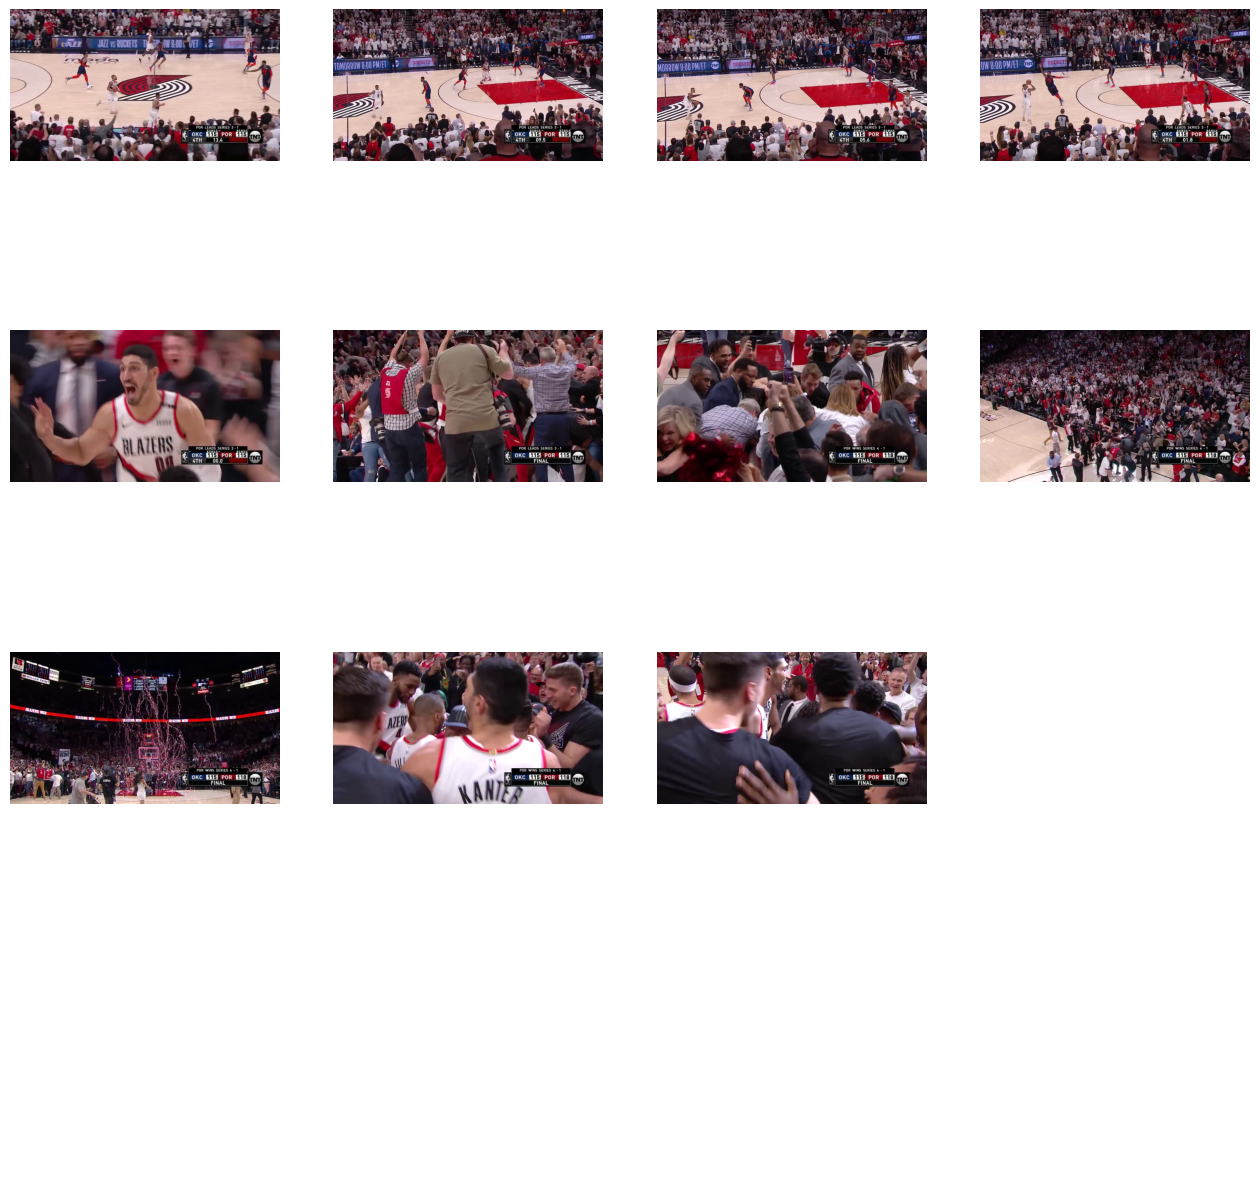

In [9]:
sv.plot_images_grid(frames, grid_size=(4, 4), size=(16, 16))

## Describing Video

In [32]:
def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode('.jpg', image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {
        "type": "text",
        "text": prompt
    }
    image_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"
            }
        }
        for image
        in images
    ]
    return {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [text_content] + image_content
            }
        ],
        "max_tokens": 300
    }


def compose_headers(api_key: str) -> dict:
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if 'error' in response:
        raise ValueError(response['error']['message'])
    return response['choices'][0]['message']['content']

In [33]:
description = prompt_image(api_key=OPENAI_API_KEY, images=frames, prompt=PROMPT)

In [34]:
description

'"HE BRINGS THE BALL UP THE COURT! TIED GAME, FOLKS!"\n\n"THE CROWD IS ON EDGE! 9.5 SECONDS LEFT!"\n\n"HE\'S DRIBBLING FAR BACK! WHAT\'S HE PLANNING?"\n\n"HE TAKES THE SHOT! FROM WAY DOWNTOWN!!"\n\n"IT\'S GOOD!!! UNBELIEVABLE!!!"\n\n"THE TEAM RUSHES TO CELEBRATE! WHAT A FINISH!!"\n\n"PURE ECSTASY IN THE ARENA! THEY CAN\'T BELIEVE IT!"\n\n"THE FANS GO WILD! STREAMERS EVERYWHERE!!!"\n\n"THEY PULL OFF THE WIN! WHAT A SERIES VICTORY!!"\n\n"THAT\'S ALL SHE WROTE! THEY\'RE MOVIN\' ON!!!"'

## Text to speach

In [38]:
client = OpenAI(api_key=OPENAI_API_KEY)

response = client.audio.speech.create(
    model="tts-1",
    voice="alloy",
    input=description,
)

response.stream_to_file("output.mp3")